# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=SyntaxWarning) 

In [2]:
import nibabel as nib
import numpy as np
import pandas as pd
import math
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import masking as nimask
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import math 
import os
from scripts.eda_func import *

# Define what data to use

In [3]:
#Define what data to use
data_folder = 'ADHD200_17'

#If a mac
mac = True
path_addon = '.nosync' if mac == True else ''

#Regions
num_of_regions = 17
regions = [f"ROI_{i+1}" for i in range(num_of_regions)]

# Read in the data

In [4]:
#Just run ones
mean, var = get_mean_and_var_stats(data_folder = data_folder, 
                                   mac = True)

#Load mean and variance
mean_pr_roi = pd.read_csv(f'data{path_addon}/stats/{data_folder}_mean_subject.csv', 
                          sep = ';',
                          index_col = 'Unnamed: 0')
var_pr_roi = pd.read_csv(f'data{path_addon}/stats/{data_folder}_variance_subject.csv', 
                         sep = ';',
                         index_col = 'Unnamed: 0')

#Expand subject ID
mean_pr_roi['Subject_ID'] = mean_pr_roi['Subject_ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))
#Expand subject ID
var_pr_roi['Subject_ID'] = var_pr_roi['Subject_ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))

print('Mean Shape:', mean_pr_roi.shape)
print('Variance Shape:', var_pr_roi.shape)

100%|██████████| 394/394 [02:33<00:00,  2.56it/s]

Mean Shape: (394, 20)
Variance Shape: (394, 20)


### Add extra meta data

In [5]:
meta_data = pd.read_csv('data.nosync/phenotypic/ADHD200_phenotypic.csv')
#Expand subject ID
meta_data['ScanDir ID'] = meta_data['ScanDir ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))
#Select columns
meta_data = meta_data[['ScanDir ID', 'Gender', 'DX']]
#Replace values
meta_data['DX'] = meta_data['DX'].replace({0: 'TD', 1: 'ADHD-Combined', 2: 'ADHD-Hyperactive/Impulsive', 3: 'ADHD-Inattentive'})
meta_data['Gender'] = meta_data['Gender'].replace({0: 'Female', 1: 'Male'})

meta_data = meta_data.drop_duplicates('ScanDir ID')

#Merge with scans
mean_pr_roi = pd.merge(left = mean_pr_roi, 
                        right = meta_data,
                        left_on= 'Subject_ID',
                        right_on= 'ScanDir ID')

var_pr_roi = pd.merge(left = var_pr_roi, 
                        right = meta_data,
                        left_on= 'Subject_ID',
                        right_on= 'ScanDir ID')

# EDA

## Describe the data

### Gender & Diagnosis

In [6]:
print('Number of unique subjects:', len(mean_pr_roi['Subject_ID'].unique()))
print('=' * 30)
print('Scanes from males:', mean_pr_roi['Gender'].value_counts()[0])
print('Scanes from females:', mean_pr_roi['Gender'].value_counts()[1])
print('=' * 30)
print('Number of TD scans:', mean_pr_roi['DX'].value_counts()[0])
print('Number of ADHD-Combined scans:', mean_pr_roi['DX'].value_counts()[1])
print('Number of ADHD-Inattentive scans:', mean_pr_roi['DX'].value_counts()[2])
print('Number of ADHD-Hyperactive/Impulsive:', mean_pr_roi['DX'].value_counts()[3])

Number of unique subjects: 216
Scanes from males: 253
Scanes from females: 139
Number of TD scans: 183
Number of ADHD-Combined scans: 127
Number of ADHD-Inattentive scans: 82
Number of ADHD-Hyperactive/Impulsive: 2


In [7]:
mean_pr_roi[['Gender', 'DX']].value_counts()

Gender  DX                        
Male    ADHD-Combined                 105
Female  TD                             94
Male    TD                             89
        ADHD-Inattentive               57
Female  ADHD-Inattentive               25
        ADHD-Combined                  20
Male    ADHD-Hyperactive/Impulsive      2
Name: count, dtype: int64

### Numerical values

In [8]:
#Describe mean stats
mean_pr_roi[regions].describe()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10,ROI_11,ROI_12,ROI_13,ROI_14,ROI_15,ROI_16,ROI_17
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,-0.012718,0.008285,-0.002298,-0.004457,0.003103,-0.001349,0.008839,0.012048,-0.008853,-0.017148,-0.000982,0.008106,0.000408,0.002442,0.000873,-0.002910,-0.002857
std,0.116663,0.175238,0.130601,0.131016,0.128455,0.113415,0.104960,0.115511,0.123784,0.296491,0.162487,0.103909,0.101015,0.115689,0.118906,0.143694,0.152350
min,-0.408036,-0.751522,-0.582952,-0.533159,-0.460258,-0.406491,-0.523751,-0.741912,-1.165905,-3.695405,-0.682993,-0.311492,-0.836240,-0.601737,-0.398836,-1.284361,-2.250226
25%,-0.078103,-0.089573,-0.062348,-0.087106,-0.062595,-0.052822,-0.052844,-0.037466,-0.049731,-0.062225,-0.099137,-0.048283,-0.053969,-0.067848,-0.074280,-0.063085,-0.054928
50%,-0.012308,0.004939,0.003668,-0.003057,0.006606,0.007096,0.009515,0.011389,-0.001031,0.001989,0.011940,0.008840,0.004705,0.002309,-0.000342,-0.002298,0.008128
75%,0.046525,0.092574,0.072241,0.071894,0.063720,0.063689,0.075998,0.078930,0.043647,0.067202,0.099838,0.065103,0.061448,0.067928,0.068853,0.071614,0.055354
max,0.618342,0.735703,0.769528,0.425964,1.445076,0.715510,0.322371,0.545376,0.373929,0.789093,0.851516,0.911843,0.292119,0.543682,0.463272,0.483787,0.387317


In [9]:
#Describe mean stats
var_pr_roi[regions].describe()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10,ROI_11,ROI_12,ROI_13,ROI_14,ROI_15,ROI_16,ROI_17
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,0.409532,0.330578,0.261194,0.279952,0.294742,0.266145,0.292120,0.295998,0.245300,0.463353,0.338195,0.271638,0.363019,0.282430,0.287153,0.383941,0.350278
std,3.790492,1.700664,1.684135,1.631815,2.009887,1.521655,1.832280,1.362002,1.259065,2.022430,1.260925,1.428002,1.567441,1.658500,1.487119,1.872460,1.802860
min,0.057037,0.067821,0.045571,0.075039,0.052300,0.056849,0.068490,0.071250,0.038289,0.054071,0.071073,0.058710,0.072134,0.076308,0.077139,0.089767,0.082629
25%,0.122254,0.146518,0.099741,0.130555,0.119988,0.118289,0.135067,0.139077,0.096619,0.132605,0.184475,0.129605,0.142368,0.135422,0.147092,0.182858,0.148936
50%,0.165269,0.204942,0.127354,0.168674,0.150742,0.151910,0.167619,0.168715,0.127347,0.196756,0.236597,0.155906,0.177407,0.164736,0.184084,0.224916,0.189387
75%,0.232507,0.286051,0.179193,0.222366,0.198847,0.193918,0.214743,0.221318,0.178656,0.346423,0.325360,0.199534,0.274582,0.208764,0.229316,0.283485,0.242129
max,75.280620,33.815681,33.403012,32.496781,39.893612,30.192235,36.453775,26.466527,24.302484,31.668767,25.102033,28.237952,27.730553,32.988926,29.593922,36.545313,34.985691


#### Remove outliers

In [10]:
#Get subject ids with to high variance
subjects_to_remove = var_pr_roi[(var_pr_roi[regions] > 2).any(axis=1)]['Subject_ID'].to_list()
subjects_to_remove

['0010077', '1023964', '0010111', '0010014']

In [11]:
var_pr_roi = var_pr_roi[~var_pr_roi['Subject_ID'].isin(subjects_to_remove)]
print(var_pr_roi.shape)
var_pr_roi[regions].describe()

(387, 23)


,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10,ROI_11,ROI_12,ROI_13,ROI_14,ROI_15,ROI_16,ROI_17
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,0.202415,0.235356,0.166161,0.191658,0.180774,0.179968,0.191064,0.206877,0.161534,0.289773,0.267379,0.185596,0.244391,0.190822,0.204523,0.265423,0.231289
std,0.162338,0.131069,0.128546,0.098397,0.113753,0.126426,0.104714,0.135230,0.127862,0.262494,0.125748,0.120840,0.206705,0.111072,0.107704,0.186787,0.172732
min,0.057037,0.067821,0.045571,0.075039,0.052300,0.056849,0.068490,0.071250,0.038289,0.054071,0.071073,0.058710,0.072134,0.076308,0.077139,0.089767,0.082629
25%,0.121379,0.145917,0.099549,0.130199,0.119770,0.117988,0.134776,0.138974,0.096230,0.131055,0.184026,0.129249,0.141830,0.134598,0.146791,0.182269,0.146537
50%,0.163825,0.202384,0.126389,0.168117,0.150251,0.151375,0.167379,0.167970,0.126401,0.194499,0.236193,0.155407,0.176423,0.163355,0.183615,0.223186,0.186496
75%,0.227245,0.283966,0.177386,0.219492,0.195767,0.191560,0.213775,0.217607,0.172979,0.336144,0.319952,0.197537,0.266809,0.207174,0.226490,0.280198,0.239674
max,1.923727,1.012389,1.016780,1.020215,1.231850,1.432025,1.037422,0.977704,1.122872,1.701934,1.078476,1.534981,1.962029,1.344233,1.400814,1.891527,1.653239


In [12]:
mean_pr_roi = mean_pr_roi[~mean_pr_roi['Subject_ID'].isin(subjects_to_remove)]
print(mean_pr_roi.shape)
mean_pr_roi[regions].describe()

(387, 23)


,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10,ROI_11,ROI_12,ROI_13,ROI_14,ROI_15,ROI_16,ROI_17
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,-0.013071,0.003971,-0.004617,-0.002627,-0.002008,-0.003425,0.010466,0.015026,-0.003662,0.002686,-0.002536,0.006341,0.004145,0.004826,0.000413,0.002742,0.003943
std,0.111737,0.169296,0.117105,0.125381,0.105371,0.102791,0.101878,0.105156,0.095351,0.135953,0.161524,0.093175,0.089073,0.109054,0.115994,0.115368,0.097949
min,-0.395048,-0.751522,-0.567150,-0.509493,-0.460258,-0.406491,-0.523751,-0.527818,-0.697683,-0.805806,-0.682993,-0.311492,-0.304044,-0.413169,-0.398836,-0.379433,-0.468774
25%,-0.077791,-0.089203,-0.062291,-0.085753,-0.063263,-0.051875,-0.051217,-0.035775,-0.048266,-0.061041,-0.100048,-0.048178,-0.051218,-0.065711,-0.073781,-0.062504,-0.053321
50%,-0.012067,0.003568,0.003485,-0.003317,0.004494,0.007502,0.011829,0.011511,-0.001200,0.001991,0.011344,0.009135,0.005970,0.002886,-0.000519,-0.002311,0.009067
75%,0.046255,0.089477,0.071312,0.070865,0.062232,0.063585,0.076649,0.078679,0.041893,0.066710,0.093880,0.064796,0.062019,0.067746,0.068753,0.071355,0.056634
max,0.618342,0.735703,0.401023,0.425964,0.425632,0.214012,0.322371,0.545376,0.373929,0.729793,0.851516,0.275105,0.292119,0.543682,0.463272,0.483787,0.387317


In [13]:
#Subject without gender
meta_data[meta_data['ScanDir ID'] == "0010044"]

,ScanDir ID,Gender,DX
116,0010044,NaN,ADHD-Combined


## Distribution plots

### Variance

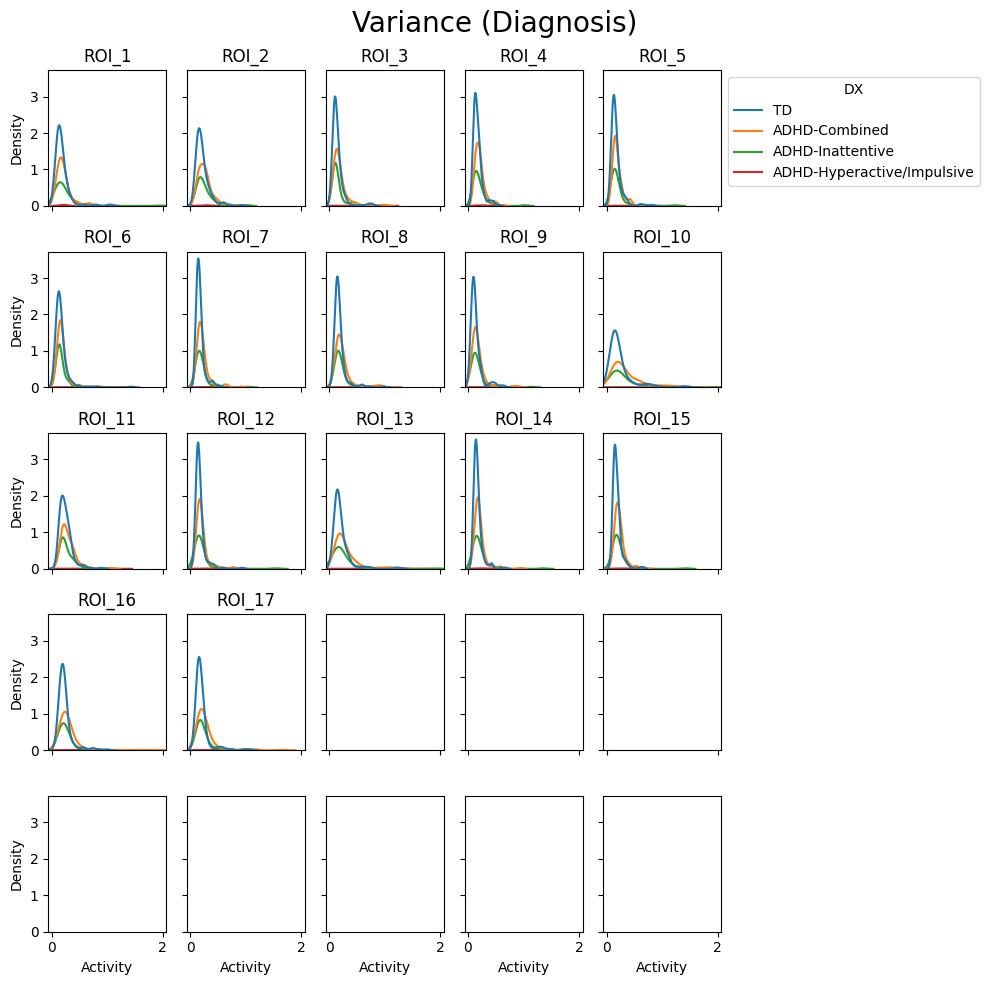

In [14]:
#Variance + diagnosis
plot_small_multiple_rois(data = var_pr_roi, regions = regions, title = 'Variance (Diagnosis)', hue_col = 'DX')

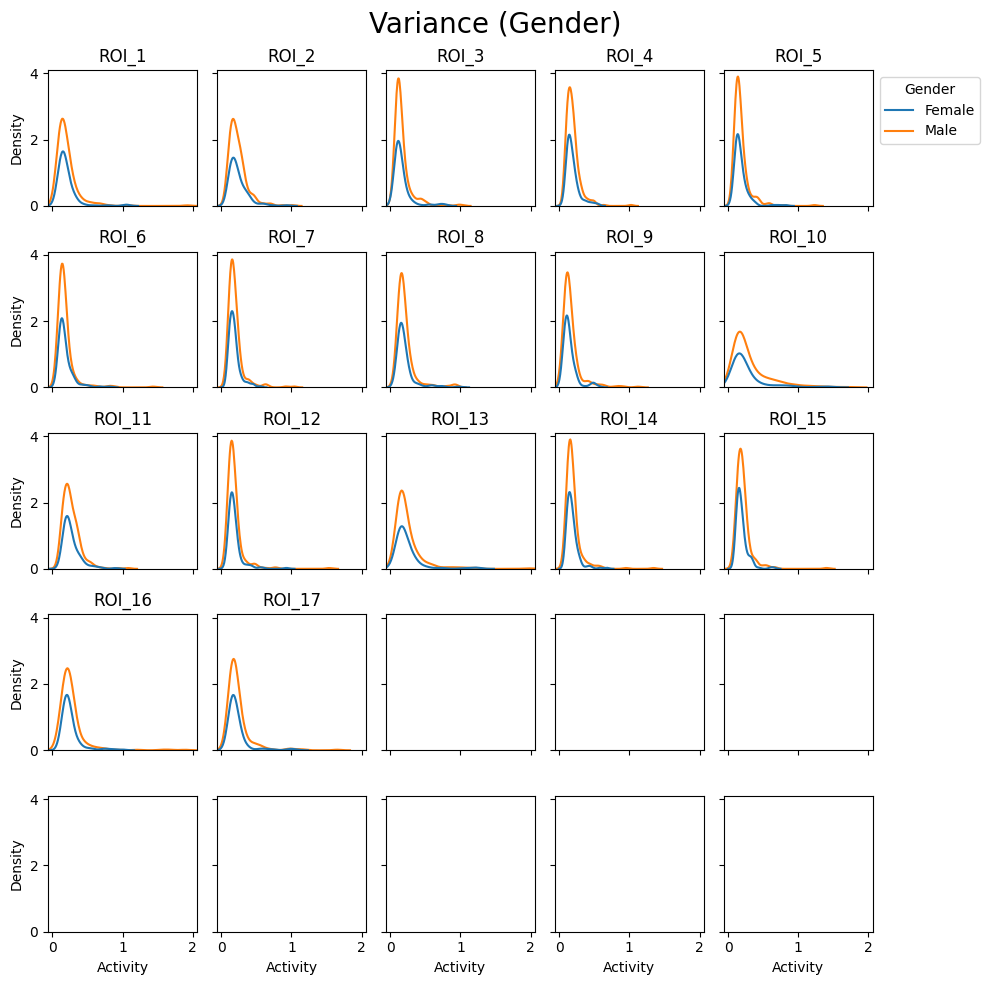

In [16]:
#Variance + gender
plot_small_multiple_rois(data = var_pr_roi, regions = regions, title = 'Variance (Gender)', hue_col = 'Gender')

### Mean

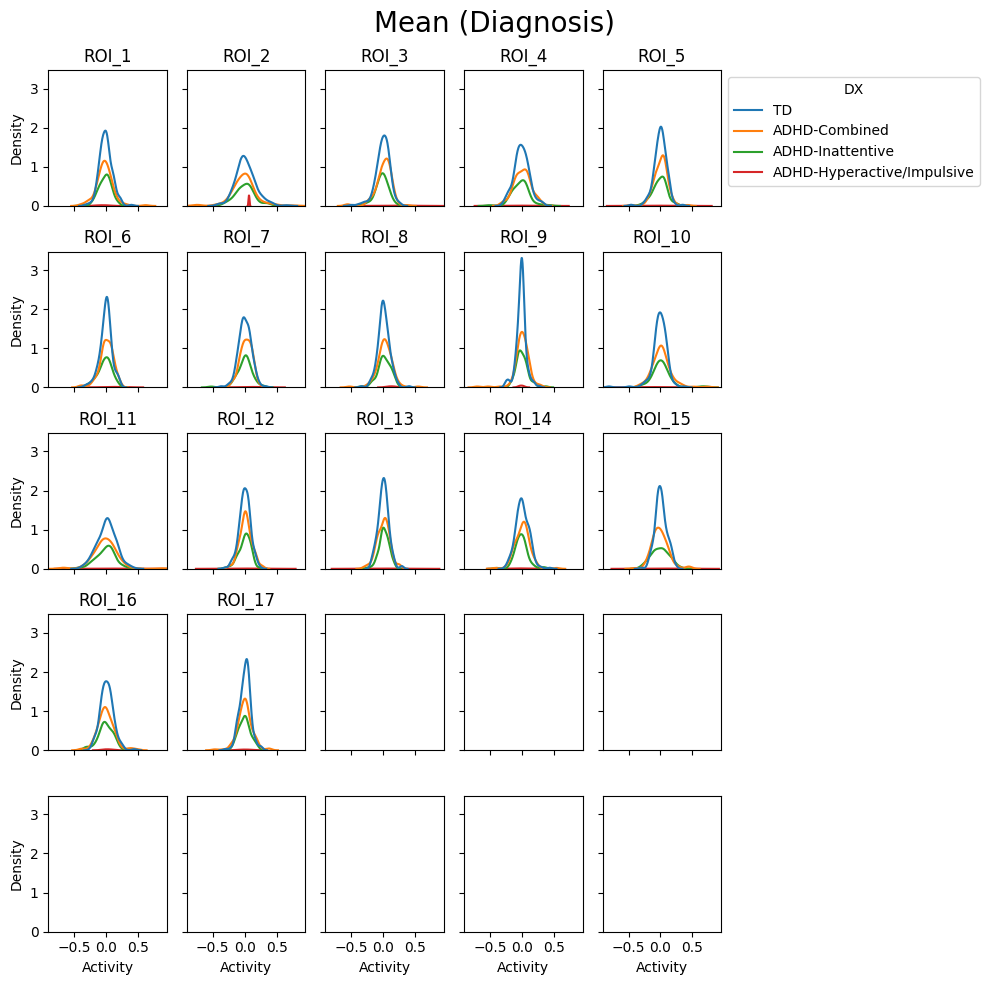

In [17]:
#Mean + diagnosis
plot_small_multiple_rois(data = mean_pr_roi, regions = regions, title = 'Mean (Diagnosis)', hue_col = 'DX')

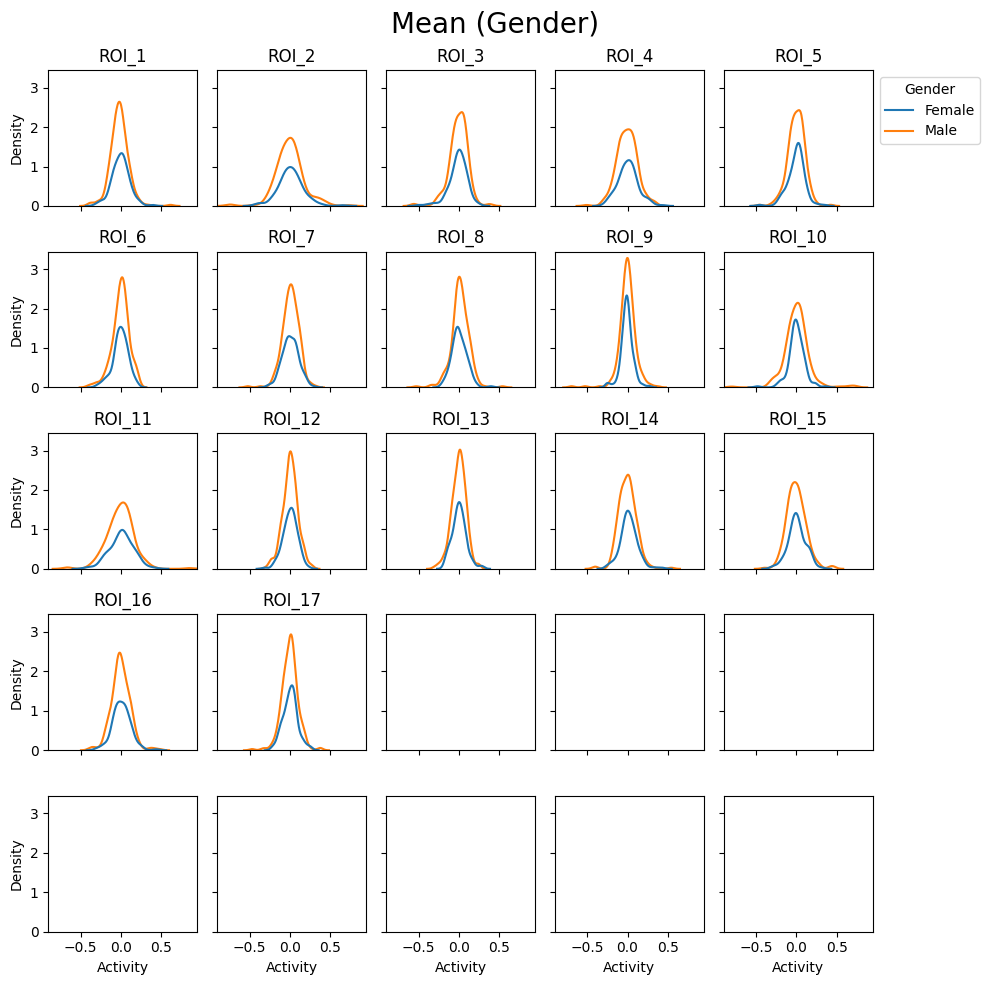

In [18]:
#Mean + gender
plot_small_multiple_rois(data = mean_pr_roi, regions = regions, title = 'Mean (Gender)', hue_col = 'Gender')

#### Check for different distributions (p-values)

##### Variance

In [19]:
print("-"*20,'Variance',"-"*20)
test_dist(data = var_pr_roi, regions = regions)
print('\n')
print("-"*10,'Without ADHD-Hyperactive/Impulsive',"-"*10)
test_dist(data = var_pr_roi[var_pr_roi['DX'] != 'ADHD-Hyperactive/Impulsive'], regions = regions)

-------------------- Variance --------------------
ROI_1 (Gender): The P-value is 0.6105976928202899
ROI_2 (Gender): The P-value is 0.9674464671311078
ROI_3 (Gender): The P-value is 0.7044409343586195
ROI_4 (Gender): The P-value is 0.6234318476543055
ROI_5 (Gender): The P-value is 0.7685283071160618
ROI_6 (Gender): The P-value is 0.9513605988488166
ROI_7 (Gender): The P-value is 0.2628574053418607
ROI_8 (Gender): The P-value is 0.6057768282183555
ROI_9 (Gender): The P-value is 0.07500875443857978
ROI_10 (Gender): The P-value is 0.09519069228893233
ROI_11 (Gender): The P-value is 0.9717497795538842
ROI_12 (Gender): The P-value is 0.9460394550041287
ROI_13 (Gender): The P-value is 0.6481797413495186
ROI_14 (Gender): The P-value is 0.2646875804724968
ROI_15 (Gender): The P-value is 0.05346501484041104
ROI_16 (Gender): The P-value is 0.355469164953653
ROI_17 (Gender): The P-value is 0.3912306977972253
##################################################
ROI_1 (Diagnosis): The P-value is 0.24

##### Mean

In [20]:
print("-"*20,'Mean',"-"*20)
test_dist(data = mean_pr_roi, regions = regions)

-------------------- Mean --------------------
ROI_1 (Gender): The P-value is 0.18778048647014792
ROI_2 (Gender): The P-value is 0.5256490237936724
ROI_3 (Gender): The P-value is 0.6515894863478731
ROI_4 (Gender): The P-value is 0.30485269177738783
ROI_5 (Gender): The P-value is 0.9627354400563792
ROI_6 (Gender): The P-value is 0.9148682134752701
ROI_7 (Gender): The P-value is 0.859754668356123
ROI_8 (Gender): The P-value is 0.36261579335093896
ROI_9 (Gender): The P-value is 0.4683620442940437
ROI_10 (Gender): The P-value is 0.8490359445445423
ROI_11 (Gender): The P-value is 0.37974650213785477
ROI_12 (Gender): The P-value is 0.9171415298034438
ROI_13 (Gender): The P-value is 0.606887407532261
ROI_14 (Gender): The P-value is 0.0946462363161862
ROI_15 (Gender): The P-value is 0.5473234688270106
ROI_16 (Gender): The P-value is 0.42833951300080464
ROI_17 (Gender): The P-value is 0.5832174933641919
##################################################
ROI_1 (Diagnosis): The P-value is 0.54532

# Heatmaps

## Variance

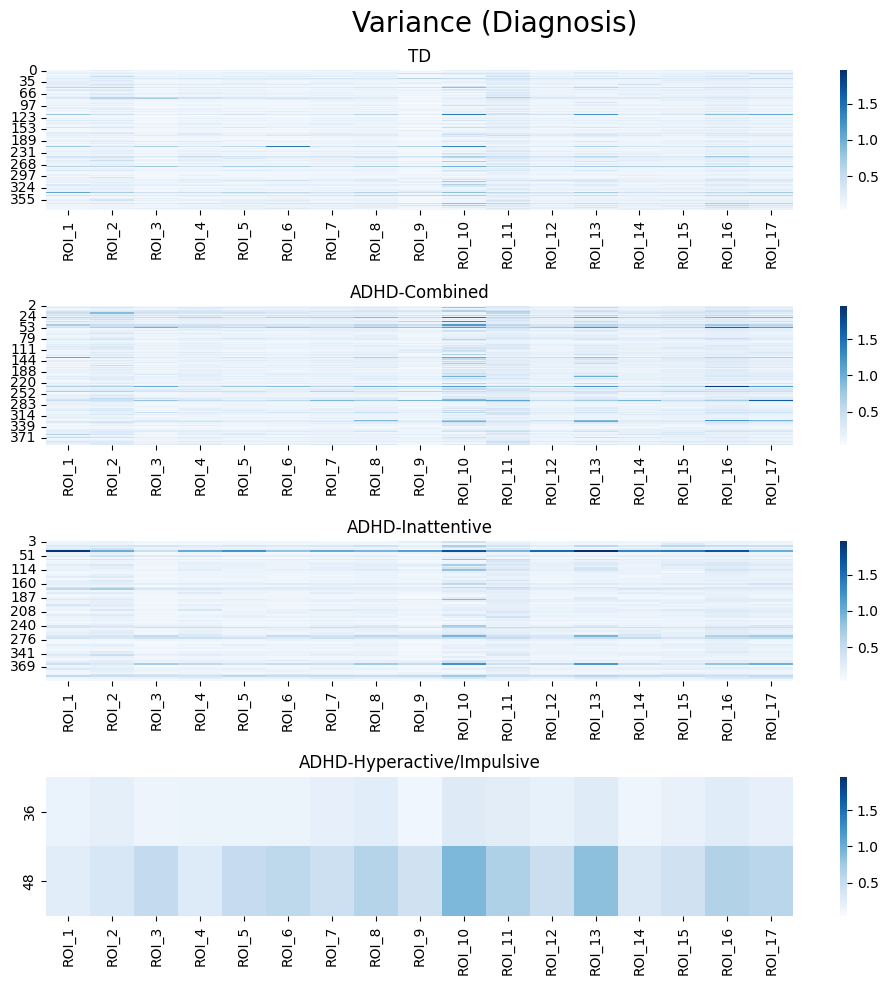

In [21]:
group_roi_heat_map(data = var_pr_roi, group = 'DX', title = 'Variance (Diagnosis)', regions = regions)

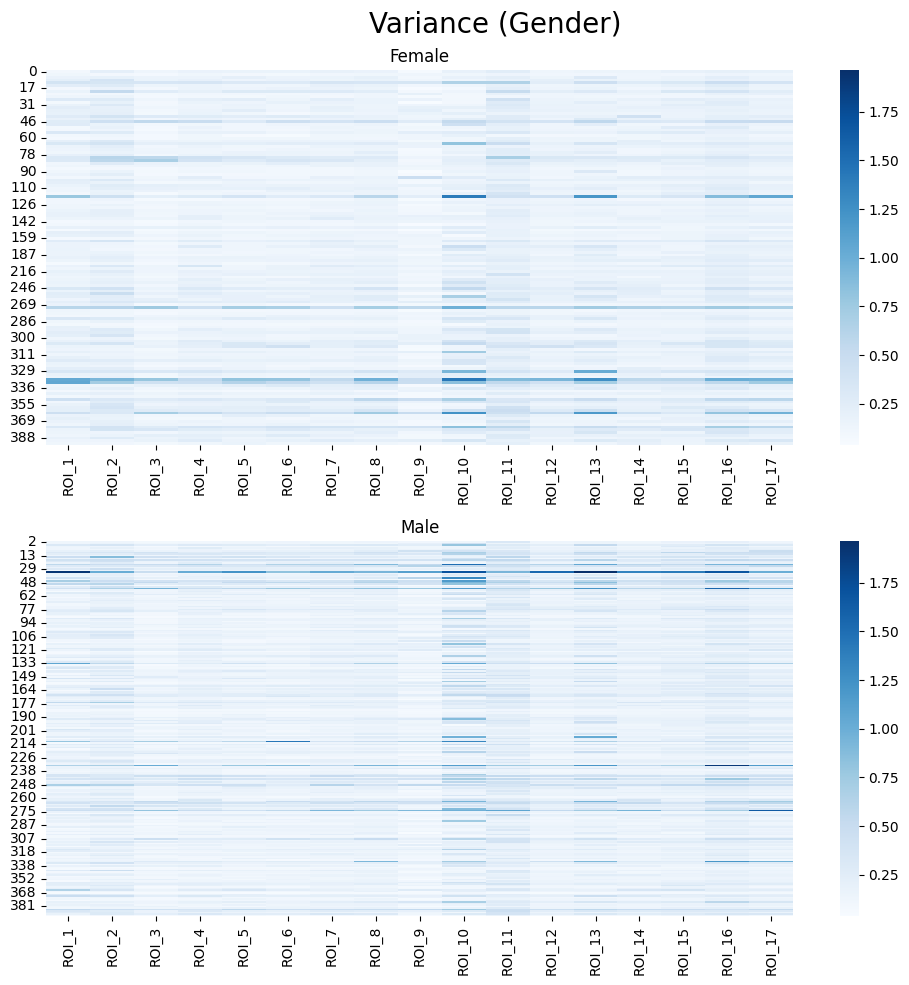

In [22]:
group_roi_heat_map(data = var_pr_roi, group = 'Gender', title = 'Variance (Gender)', regions = regions)

## Mean

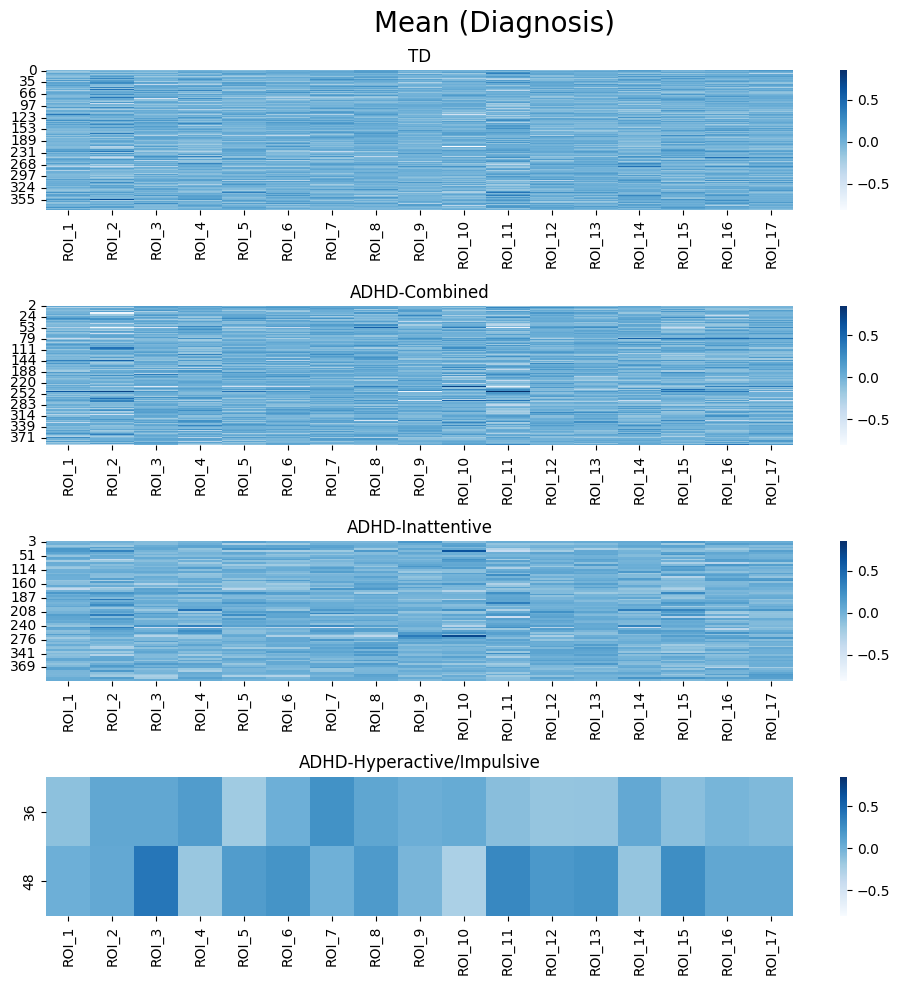

In [25]:
group_roi_heat_map(data = mean_pr_roi, group = 'DX', title = 'Mean (Diagnosis)', regions = regions)

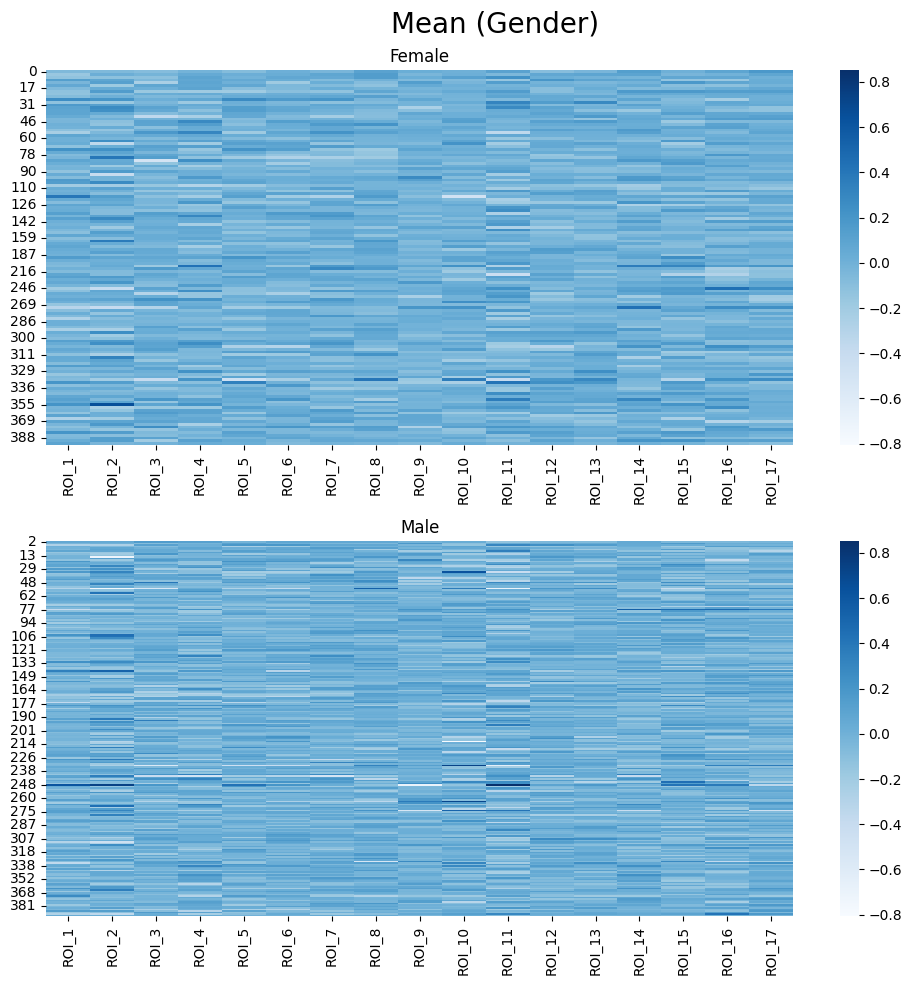

In [24]:
group_roi_heat_map(data = mean_pr_roi, group = 'Gender', title = 'Mean (Gender)', regions = regions)

## TODO
&#x2611; explore variance strangeness

&#x2611; explore means in same way
* Visualizing global patterns over time https://nilearn.github.io/dev/auto_examples/01_plotting/plot_carpet.html
* region activity over time https://nilearn.github.io/dev/auto_examples/06_manipulating_images/plot_nifti_labels_simple.html#sphx-glr-auto-examples-06-manipulating-images-plot-nifti-labels-simple-py


NameError: name 'means_pr_roi' is not defined

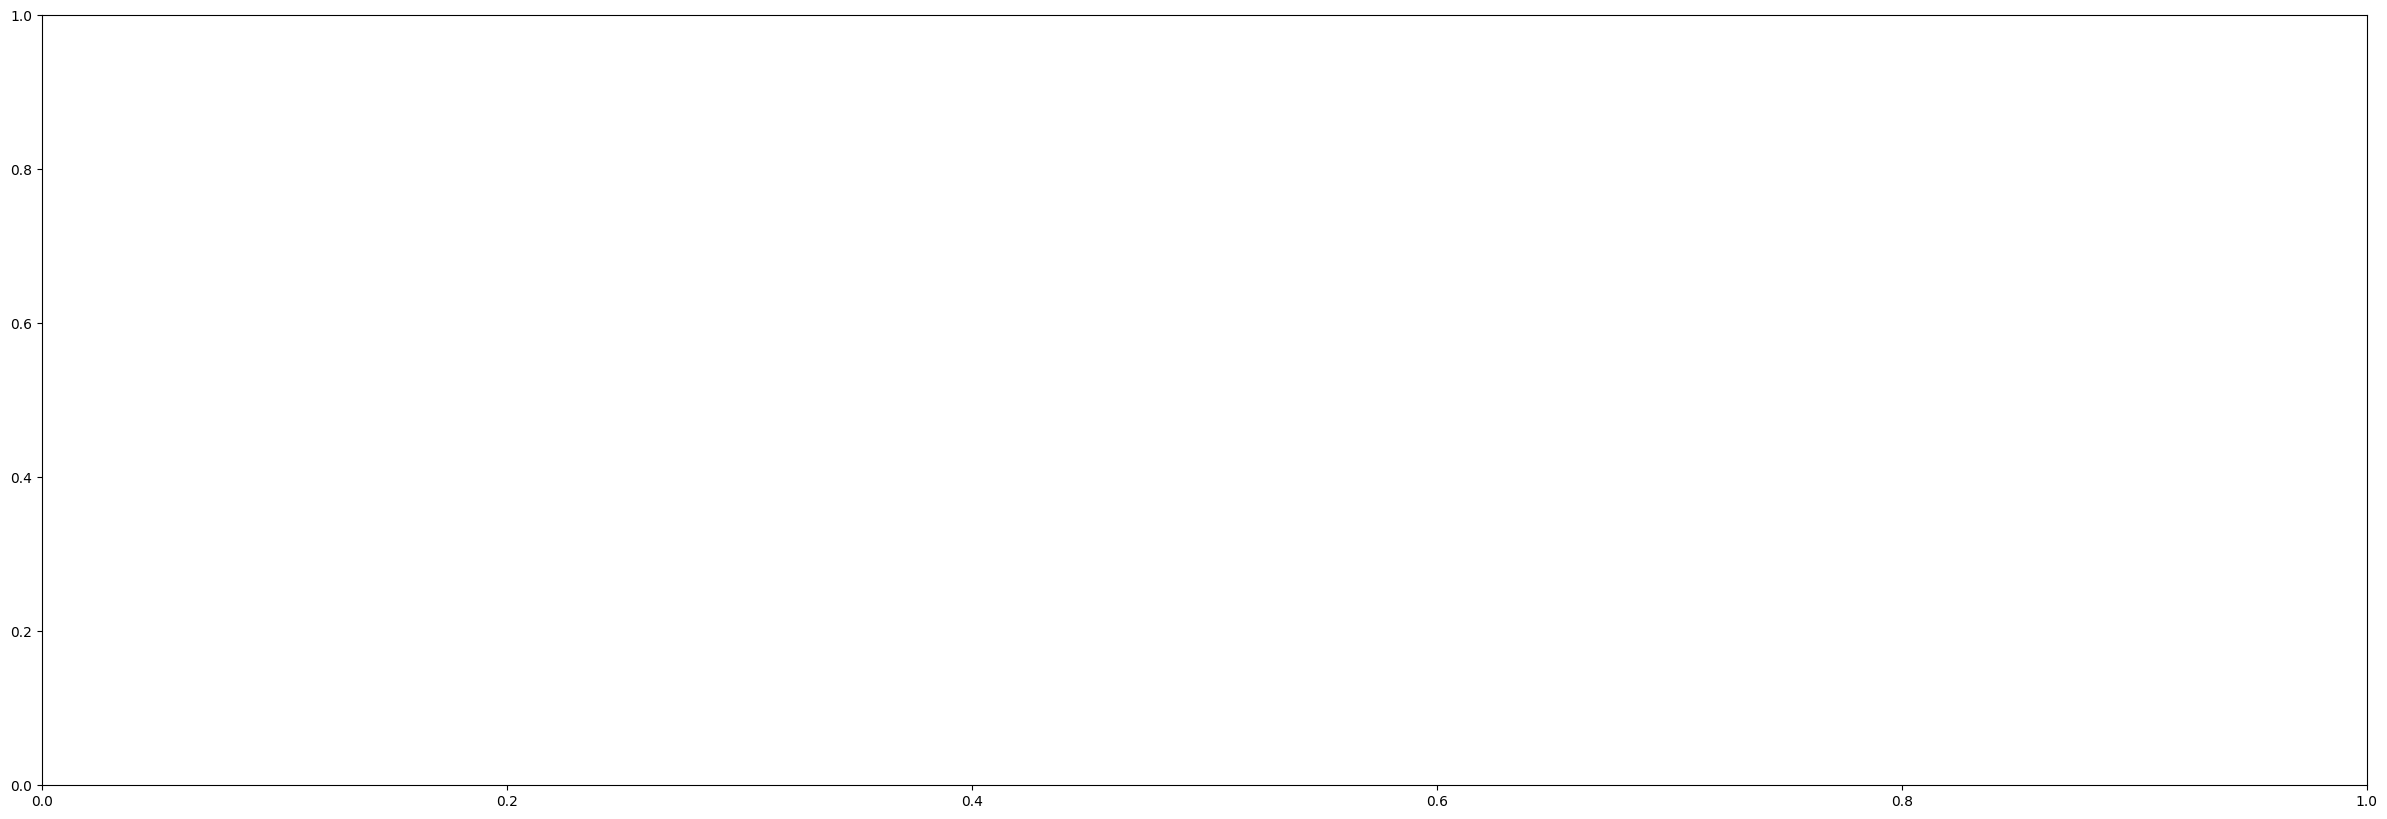

In [24]:
#WRONG! TODO fix, see below :)
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)


for i in means_pr_roi.loc[:, means_pr_roi.columns != "subject"]: #For each ROI 
    ax.plot(
        means_pr_roi[i], linewidth=2, label=i,alpha = 0.7
            ) #would be super cool to align the colour to a diagnosis #TODO exclude huge values

ax.legend(loc=2)
ax.set_title("Signals for first 3 regions")
plt.show()

In [ ]:
# for subject in tqdm(file_list): #For each subject

#     subject = np.load(f'data/clean/NYU/{subject}')
#     for i in subject.files: #For each ROI 
#         if i != "allow_pickle": #TODO fix, there is a strange "Allow pickle thing here sometimes??"
#             roi = subject[i]
#             values = pd.DataFrame()
#             #Get all values from each timestep
#             for t in range(roi.shape[0]):
#                 values[t] = roi[t] #appends
#     break
